In [2]:
import numpy as np
import torch.optim as optim
import math
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchmetrics.functional import dice
import torch.nn.functional as F
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.resnet import ResNet50_Weights
from unets import UNet, UNetPlusPlus
import matplotlib.pyplot as plt
import csv
from scipy.ndimage import rotate
import itertools

Data Exploration

Statistics about the data + sample images + noise identification

In [ ]:
# TODO: add code here for what is described above

Data Augmentation - rotating and mirroring the images

To run it you need to download the dataset sample from the link provided in the end of the report. You may also need to change the path to the folder. The given script augments the whole dataset which we could not share because of an NDA (but Ole should have access to it).

In [4]:
# Make sure the path to the arrays folder is correct
ARRAYS_FOLDER = './test_set/'
ROTATED_FOLDER = './arrays_rotated/'


def rotate_images(image, target, angle):
    image = rotate(image, angle, reshape=False, order=0)
    target = rotate(target, angle, reshape=False, order=0)
    return image, target


def mirror_images(image, target):
    image = np.fliplr(image)
    target = np.fliplr(target)
    return image, target


def preprocess_file(files, shouldRotate=False, shouldMirror=False, angle=0):
    for file in files:
        new_file_name = ''
        file_path = os.path.join(ARRAYS_FOLDER, file)
        sample_tensor = np.load(file_path)

        original_image_data = sample_tensor[:, :, 0:3]  # First 3 channels are the image data
        augmented_image_data = original_image_data

        original_target = sample_tensor[:, :, 3]  # Fourth channel contains target values
        original_target = np.expand_dims(original_target, axis=-1)  # Add third dimension to the target
        augmented_target = original_target

        if shouldRotate and angle != 0:
            new_file_name += "angle_" + str(angle) + "_"
            augmented_image_data, augmented_target = rotate_images(augmented_image_data, augmented_target, angle)

        if shouldMirror:
            new_file_name += "mirrored_"
            augmented_image_data, augmented_target = mirror_images(augmented_image_data, augmented_target)

        # Save the augmented images and targets
        augmented_file_path = os.path.join(ROTATED_FOLDER, f"{new_file_name}{file}")
        np.save(augmented_file_path, np.concatenate([augmented_image_data, augmented_target], axis=-1))


def getRandomAngles():
    return np.random.choice([45, 90, 135, 180, 225, 270, 315])


def preprocess_input():
    black_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.startswith('black_5') and f.endswith('.npy')]
    photo_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.startswith('photo') and f.endswith('.npy')]
    orange_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.startswith('orange') and f.endswith('.npy')]

    # The original images must always be saved here!!!

    # Preprocess photo images
    preprocess_file(photo_files, shouldRotate=True, angle=45)
    preprocess_file(photo_files, shouldRotate=True, angle=90)
    preprocess_file(photo_files, shouldRotate=True, angle=135)
    preprocess_file(photo_files, shouldRotate=True, angle=180)
    preprocess_file(photo_files, shouldRotate=True, angle=225)
    preprocess_file(photo_files, shouldRotate=True, angle=270)
    preprocess_file(photo_files, shouldRotate=True, angle=315)
    preprocess_file(photo_files, shouldRotate=True, angle=45, shouldMirror=True)
    preprocess_file(photo_files, shouldRotate=True, angle=90, shouldMirror=True)
    preprocess_file(photo_files, shouldRotate=True, angle=135, shouldMirror=True)
    preprocess_file(photo_files, shouldRotate=True, angle=180, shouldMirror=True)
    preprocess_file(photo_files, shouldRotate=True, angle=225, shouldMirror=True)
    preprocess_file(photo_files, shouldRotate=True, angle=270, shouldMirror=True)
    preprocess_file(photo_files, shouldRotate=True, angle=315, shouldMirror=True)
    preprocess_file(photo_files, shouldMirror=True)
    # Save original images
    for file in photo_files:
        original_file_path = os.path.join(ROTATED_FOLDER, f"original_{file}")
        file_path = os.path.join(ARRAYS_FOLDER, file)
        tensor = np.load(file_path)
        np.save(original_file_path, tensor)

    # Preprocess black images
    preprocess_file(black_files, shouldRotate=True, angle=getRandomAngles())
    # Save original images
    for file in black_files:
        original_file_path = os.path.join(ROTATED_FOLDER, f"original_{file}")
        file_path = os.path.join(ARRAYS_FOLDER, file)
        tensor = np.load(file_path)
        np.save(original_file_path, tensor)

    # Preprocess orange images
    for file in orange_files:
        original_file_path = os.path.join(ROTATED_FOLDER, f"original_{file}")
        file_path = os.path.join(ARRAYS_FOLDER, file)
        tensor = np.load(file_path)
        np.save(original_file_path, tensor)


# Create the rotated folder if it doesn't exist
if not os.path.exists(ROTATED_FOLDER):
    os.makedirs(ROTATED_FOLDER)

# Call the preprocess_input function
preprocess_input()

In [ ]:
# TODO: print an image - original, rotated and mirrored

U-Net and U-Net++ model implementations + function to generate the transfer learning model

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            # We use bias=False because it is cancelled out by the batchnorm
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, factor=2):
        super().__init__()
        # output shape excluding channels (same for both height and width) is:
        # out = (in - 1) * stride - 2 * padding + (kernel_size - 1) + 1
        # here, with padding = 0, we get:
        # out = (stride * in) - (2 * stride) + kernel
        self.up = nn.ConvTranspose2d(in_channels * 2, in_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels * factor, out_channels, out_channels)

    def forward(self, x1, x2, x3=None, x4=None, x5=None):
        x1 = self.up(x1)
        tensors = [x2]
        if x3 is not None:
            tensors.append(x3)
        if x4 is not None:
            tensors.append(x4)
        if x5 is not None:
            tensors.append(x5)

        tensors.append(x1)
        x = torch.cat(tensors, dim=1)  # all tensors need to have the same number of channels
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # the CrossEntropyLoss automatically wraps this in a LogSoftmax, that's why we don't do it here
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3):
        super(UNet, self).__init__()

        self.inc = (ConvBlock(n_channels, 64, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(512, 512))
        self.up2 = (Up(256, 256))
        self.up3 = (Up(128, 128))
        self.up4 = (Up(64, 64))
        self.outc = (OutConv(64, 9))

    def forward(self, x):
        x1 = self.inc(x)  # x1 HxW: 256x256
        x2 = self.down1(x1)  # x2 HxW: 128x128
        x3 = self.down2(x2)  # x3 HxW: 64x64
        x4 = self.down3(x3)  # x4 HxW: 32x32
        x5 = self.down4(x4)  # x5 HxW: 16x16
        x = self.up1(x5, x4)  # up(x5) gives 32x32, concat with x4, HxW remains 32x32 and the channels are added
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class UNetPlusPlus(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0_0 = ConvBlock(3, 64, 64)
        self.down1_0 = Down(64, 128)
        self.down2_0 = Down(128, 256)
        self.down3_0 = Down(256, 512)
        self.down4_0 = Down(512, 1024)

        self.up0_1 = Up(64, 64)
        self.up1_1 = Up(128, 128)
        self.up2_1 = Up(256, 256)
        self.up3_1 = Up(512, 512)

        self.up0_2 = Up(64, 64, 3)
        self.up1_2 = Up(128, 128, 3)
        self.up2_2 = Up(256, 256, 3)

        self.up0_3 = Up(64, 64, 4)
        self.up1_3 = Up(128, 128, 4)

        self.up0_4 = Up(64, 64, 5)

        self.outc = OutConv(64, 9)

    def forward(self, input):
        x0_0 = self.conv0_0(input)  # 256x256
        x1_0 = self.down1_0(x0_0)  # 128x128
        x0_1 = self.up0_1(x1_0, x0_0)  # 256x256

        x2_0 = self.down2_0(x1_0)  # 64x64
        x1_1 = self.up1_1(x2_0, x1_0)  # 128x128
        x0_2 = self.up0_2(x1_1, x0_0, x0_1)  # 256x256

        x3_0 = self.down3_0(x2_0)  # 32x32
        x2_1 = self.up2_1(x3_0, x2_0)  # 64x64
        x1_2 = self.up1_2(x2_1, x1_0, x1_1)  # 128x128
        x0_3 = self.up0_3(x1_2, x0_0, x0_1, x0_2)  # 256x256

        x4_0 = self.down4_0(x3_0)  # 16x16
        x3_1 = self.up3_1(x4_0, x3_0)  # 32x32
        x2_2 = self.up2_2(x3_1, x2_0, x2_1)  # 64x64
        x1_3 = self.up1_3(x2_2, x1_0, x1_1, x1_2)  # 128x128
        x0_4 = self.up0_4(x1_3, x0_0, x0_1, x0_2, x0_3)  # 256x256

        logits = self.outc(x0_4)
        return logits
    
    
def get_pretrained_model():
    pretrained_model = fcn_resnet50(weights_backbone=ResNet50_Weights.DEFAULT)
    pretrained_model.classifier[-1] = UNet(512)

    for p in pretrained_model.backbone.parameters():
        p.requires_grad = False

    return pretrained_model    

The complete model training pipeline:

    - reading the augmented input and mapping it to tensors
    - generating the train, validation, test datasets
    - defining the helper functions: calculate, show and save dice coefficient, save model, initialize weights etc.
    - train function to train the U-Net++

In [ ]:
BATCH_SIZE = 32
image_data_list = []
target_list = []

npy_files = [f for f in os.listdir(ROTATED_FOLDER) if f.endswith('.npy')]
for file in npy_files:
    file_path = os.path.join(ROTATED_FOLDER, file)
    npy_file = np.load(file_path)
    image = torch.from_numpy(npy_file[:, :, 0:3]) / 255
    image = image.permute(2, 0, 1)
    target = torch.as_tensor((npy_file[:, :, 3] % 90) // 10, dtype=torch.long)
    image_data_list.append(image)
    target_list.append(target)

images_tensor = torch.stack(image_data_list, dim=0)
masks_tensor = torch.stack(target_list, dim=0)
dataset = TensorDataset(images_tensor, masks_tensor)

DATASET_LENGTH = len(dataset)
train_size = math.floor(DATASET_LENGTH * 0.8)
val_size = math.floor(DATASET_LENGTH * 0.1)
test_size = DATASET_LENGTH - train_size - val_size

generator_seed = torch.Generator().manual_seed(0)
train_set, temp_set = random_split(dataset, [train_size, val_size + test_size], generator=generator_seed)
val_set, test_set = random_split(temp_set, [val_size, test_size], generator=generator_seed)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

r_map = {0: 0, 10: 250, 20: 19, 30: 249, 40: 10, 50: 149, 60: 5, 70: 20, 80: 249, 90: 0}
g_map = {0: 0, 10: 149, 20: 98, 30: 249, 40: 248, 50: 7, 60: 249, 70: 19, 80: 9, 90: 0}
b_map = {0: 0, 10: 10, 20: 19, 30: 10, 40: 250, 50: 149, 60: 9, 70: 249, 80: 250, 90: 0}

class_color_map = {
    0: (r_map[0], g_map[0], b_map[0]),
    1: (r_map[10], g_map[10], b_map[10]),
    2: (r_map[20], g_map[20], b_map[20]),
    3: (r_map[30], g_map[30], b_map[30]),
    4: (r_map[40], g_map[40], b_map[40]),
    5: (r_map[50], g_map[50], b_map[50]),
    6: (r_map[60], g_map[60], b_map[60]),
    7: (r_map[70], g_map[70], b_map[70]),
    8: (r_map[80], g_map[80], b_map[80]),
    9: (r_map[90], g_map[90], b_map[90]),
}


def save_loss_accuracy_to_file(train_losses, train_dices, val_losses, val_accuracies, class_color_map, file_path='dices_original.csv'):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        header = ['Epoch', 'Train Loss'] + [f'Train Dice Class {i} (Color: {class_color_map[i]})' for i in range(len(train_dices[0]))] + [
            'Validation Loss', 'Validation Accuracy']
        csv_writer.writerow(header)
        for epoch, train_loss, train_dices_epoch, val_loss, val_accuracy in zip(range(1, len(train_losses) + 1),
                                                                              train_losses, train_dices,
                                                                              val_losses,
                                                                              val_accuracies):
            row = [epoch, train_loss] + train_dices_epoch + [val_loss, val_accuracy]
            csv_writer.writerow(row)


def dice_coeff(outputs, targets):
    outputs = F.softmax(outputs, dim=1).float()
    targets = targets.long()
    return dice(outputs.argmax(dim=1), targets)


def dice_coeff_per_class(outputs, targets, num_classes):
    outputs = F.softmax(outputs, dim=1).float()
    targets = targets.long()

    dice_coeffs = torch.zeros(num_classes, dtype=torch.float)

    for i in range(num_classes):
        class_outputs = (outputs.argmax(dim=1) == i).float()
        class_targets = (targets == i).float()
        intersection = torch.sum(class_outputs * class_targets)
        union = torch.sum(class_outputs) + torch.sum(class_targets)
        dice_coeffs[i] = (2.0 * intersection) / (union + 1e-8)

    return dice_coeffs


def save_model(model, optimizer, save_path):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, save_path)
    print(f'Model saved at {save_path}')


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


def evaluate_val_test_set(model, device, loss_fn, set_length, loader):
    with torch.no_grad():
        model.eval()
        set_loss = 0
        set_dice = 0
        for inputs, masks in loader:
            inputs, masks = inputs.to(device), masks.to(device)
            output = model(inputs)
            set_loss += loss_fn(output, masks).item()

            batch_dice = dice_coeff(output, masks)
            set_dice += batch_dice

        set_dice /= len(loader)
        set_loss /= math.ceil(set_length / BATCH_SIZE)
        return set_loss, set_dice


def train_model(model, epochs, optimizer, loss_fn, save_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_steps = math.ceil(len(train_set) / BATCH_SIZE)
    train_losses = []
    val_losses = []
    train_dices = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        epoch_dice = torch.zeros(9, dtype=torch.float)
        model.train()

        for step, (inputs, masks) in enumerate(train_loader, 1):
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(inputs)

            batch_loss = loss_fn(output, masks)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()

            batch_dice = dice_coeff_per_class(output, masks, 9)
            epoch_dice += batch_dice

        epoch_dice /= train_steps
        train_dices.append(epoch_dice.tolist())  # Convert to list for saving to CSV
        train_losses.append(epoch_loss / train_steps)

        val_loss, val_acc = evaluate_val_test_set(model, device, loss_fn, len(val_set), val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch}, train loss: {train_losses[-1]}, train accuracy: {train_dices[-1]}")
        print(f"Epoch {epoch}, validation loss: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}")

        scheduler.step()  # Step the learning rate scheduler

    if save_path is not None:
        save_model(model, optimizer, save_path)

    test_loss, test_acc = evaluate_val_test_set(model, device, loss_fn, len(test_set), test_loader)
    print(f"Test loss: {test_loss}, test accuracy: {test_acc}")
    save_loss_accuracy_to_file(train_losses, train_dices, val_losses, val_accuracies, class_color_map)


model = UNetPlusPlus()
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0003)
loss_fn = nn.CrossEntropyLoss()  # this should also apply log-softmax to the output
save_path = 'model.pth'
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
train_model(model, 14, optimizer, loss_fn, save_path)

Grid search functionality for hyperparameter tuning

In [ ]:
for learning_rate, weight_decay, epochs, batch_size in itertools.product(learning_rates, weight_decays, epochs_list,
                                                                         batch_sizes):
    print(f"Testing hyperparameters: lr={learning_rate}, wd={weight_decay}, epochs={epochs}, batch_size={batch_size}")

    # Create a new model for each combination
    model = UNetPlusPlus()
    model.apply(weights_init)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    # Train the model with the current hyperparameters
    save_path = f'model_lr{learning_rate}_wd{weight_decay}_epochs{epochs}_batch{batch_size}.pth'
    train_model(model, epochs, optimizer, loss_fn, save_path)

    # Evaluate the model on the validation set
    _, val_accuracy = evaluate_val_test_set(model, device, loss_fn, len(val_set), val_loader)

    print(f"Validation accuracy: {val_accuracy}")

    # Update the best hyperparameters if the current model performs better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hyperparameters = {
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'epochs': epochs,
            'batch_size': batch_size
        }

print("Grid search complete.")
print("Best hyperparameters:", best_hyperparameters)

Helper functions for evaluating a model: predictions and dice score (both general and for each class) on the test set

In [15]:
r_map = {0:255, 10: 250, 20: 19, 30: 249, 40: 10, 50: 149, 60: 5, 70: 20, 80: 249, 90: 0}
g_map = {0:255, 10: 149, 20: 98, 30: 249, 40: 248, 50: 7, 60: 249, 70: 19, 80: 9, 90: 0}
b_map = {0:255, 10: 10, 20: 19, 30: 10, 40: 250, 50: 149, 60: 9, 70: 249, 80: 250, 90: 0}

def map_r_pixel(current_pixel):
    return r_map[current_pixel * 10]

def map_g_pixel(current_pixel):
    return g_map[current_pixel * 10]

def map_b_pixel(current_pixel):
    return b_map[current_pixel * 10]


map_r_pixel_vec = np.vectorize(map_r_pixel, otypes=['uint8'])
map_g_pixel_vec = np.vectorize(map_g_pixel, otypes=['uint8'])
map_b_pixel_vec = np.vectorize(map_b_pixel, otypes=['uint8'])

def map_npy_mask(original_mask):
    mapped_r = map_r_pixel_vec(original_mask)
    mapped_g = map_g_pixel_vec(original_mask)
    mapped_b = map_b_pixel_vec(original_mask)
    output = np.stack([mapped_r, mapped_g, mapped_b], axis=2)
    return output


def replace_rest_car(prediction, original):
    for row in range (len(original)):
        for col in range (len(original[0])):
            if original[row][col] == 9:
                prediction[row][col] = 9
                
    return prediction


def load_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Model loaded from {load_path}')
    return model, optimizer


def dice_coeff(outputs, targets):
   return dice(F.softmax(outputs, dim=1).float().argmax(dim=1), targets.long())


def present_model(model_name, model_type):
    device = torch.device('cpu')
    PHOTO_PREFIX = 'photo_'
    presentation_images = []
    presentation_targets = []
    presentation_npy = []
    
    for i in range (1, 31):
        filename = ARRAYS_FOLDER + PHOTO_PREFIX + "00"
        if i < 10:
            filename += "0"
        filename += str(i) + ".npy"
    
        npy_file = np.load(filename)
        image = torch.from_numpy(npy_file[:, :, 0:3]) / 255
        image = image.permute(2, 0, 1)

        presentation_npy.append(npy_file[:, :, 3] // 10)
        target = torch.as_tensor((npy_file[:, :, 3] % 90) // 10, dtype=torch.long)

        presentation_images.append(image)
        presentation_targets.append(target)

    presentation_images_tensor = torch.stack(presentation_images, dim=0)
    presentation_masks_tensor = torch.stack(presentation_targets, dim=0)
    presentation_dataset = TensorDataset(presentation_images_tensor, presentation_masks_tensor)
    
    loaded_model = UNetPlusPlus()
    if model_type == 'unet':
        loaded_model = UNet()
        
    loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=0.0005, weight_decay=0.0003)
    loaded_model, loaded_optimizer = load_model(loaded_model, loaded_optimizer, model_name)
    
    loaded_model.eval()
    with torch.no_grad():
        outputs = loaded_model(presentation_images_tensor)
        print(f"Dice for model {model_name} is: {dice_coeff(outputs, presentation_masks_tensor)}")
        
        for step in range(len(presentation_images)):
            input_image = presentation_images[step]
            input_image = input_image.to(device)
            prediction = loaded_model(input_image.unsqueeze(0))
            prediction = prediction.argmax(dim=1)
            prediction_npy = prediction[0].cpu().numpy()

            plt.figure(figsize=(12, 4))
    
            plt.subplot(1, 3, 1)
            plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(map_npy_mask(presentation_npy[step]))
            plt.title('Target Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(map_npy_mask(replace_rest_car(prediction_npy, presentation_npy[step])))
            plt.title('Predicted Mask')

            plt.show()

Presenting both the U-Net++ and the U-Net on the test set (which contains the first 30 images of real cars) by calculating the DICE coefficient and predicting all images. To run it you need to download the models from the link provided in the end of the report.

Model loaded from model_unetpp.pth
Dice for model model_unetpp.pth is: 0.9095718264579773


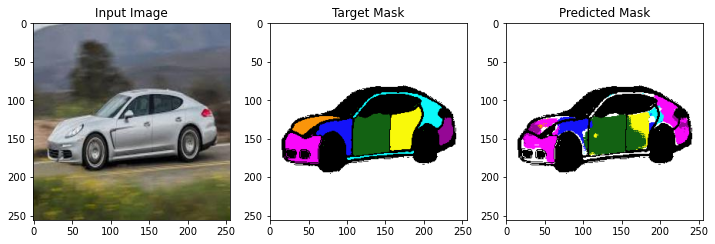

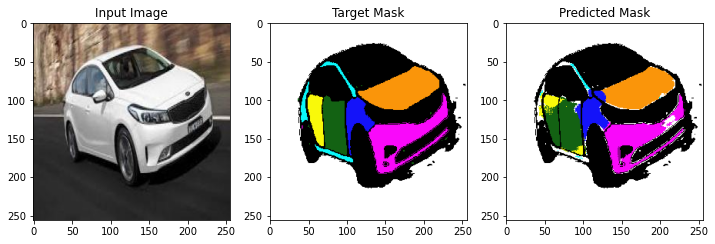

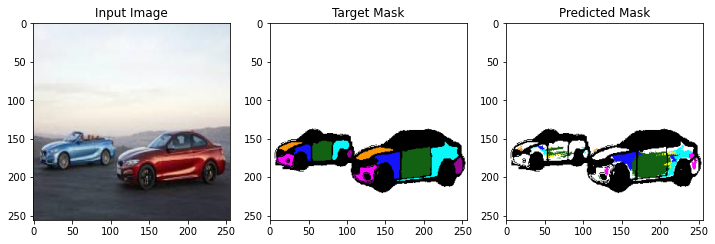

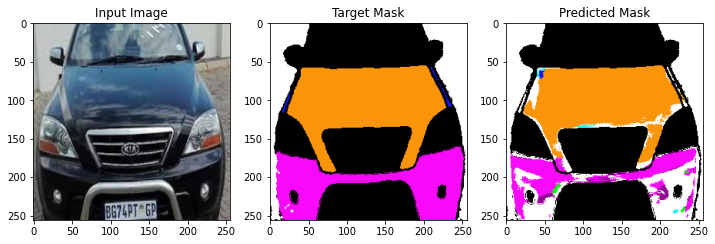

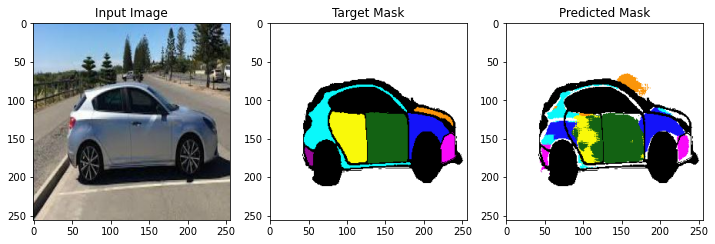

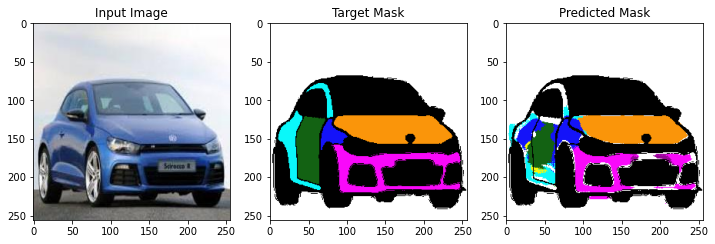

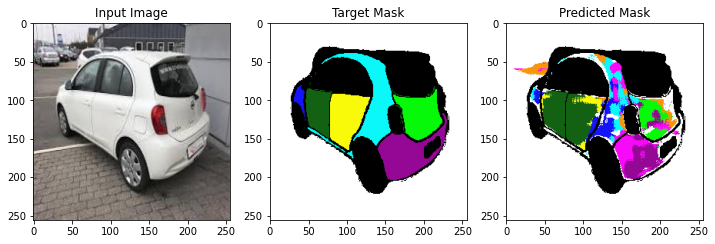

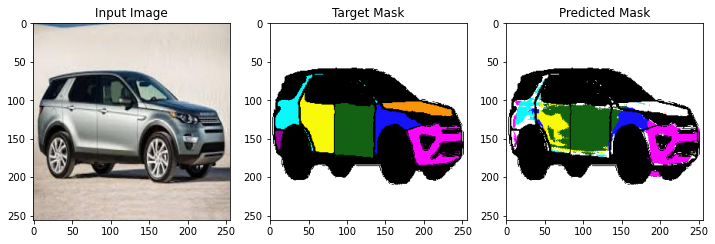

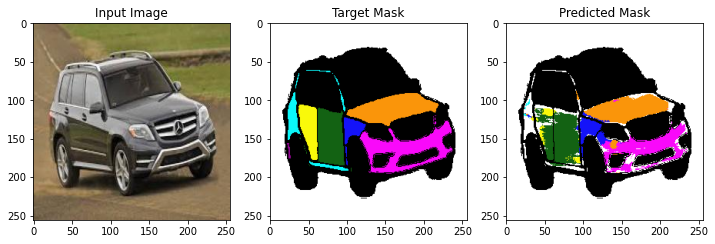

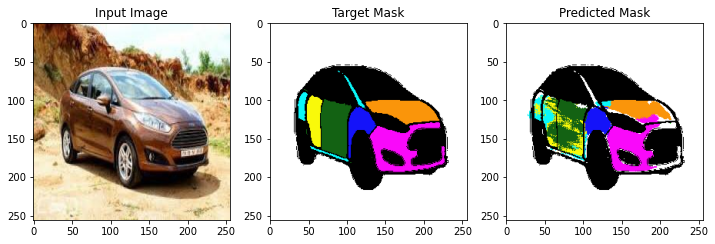

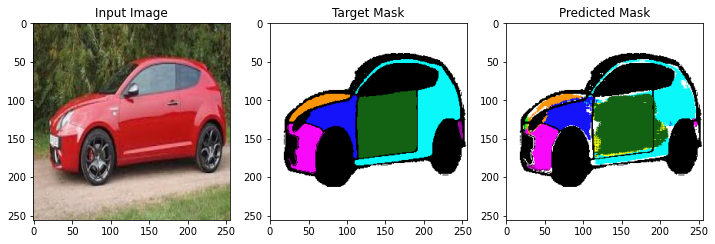

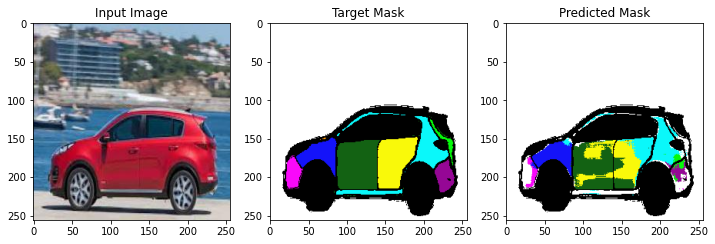

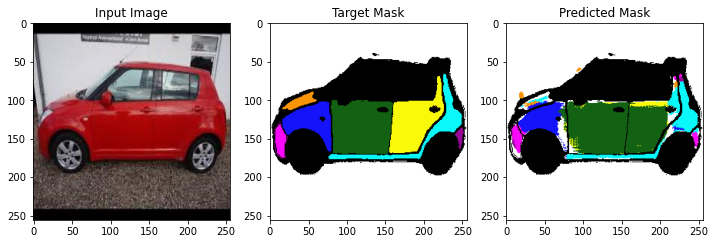

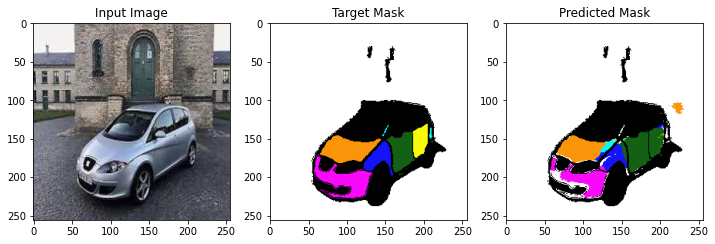

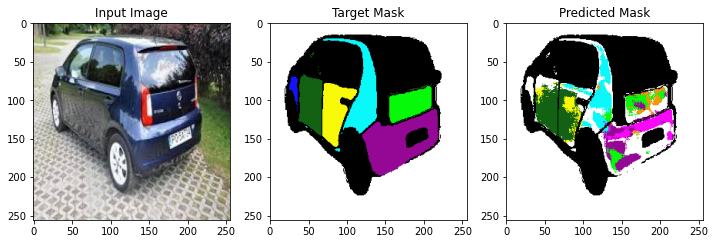

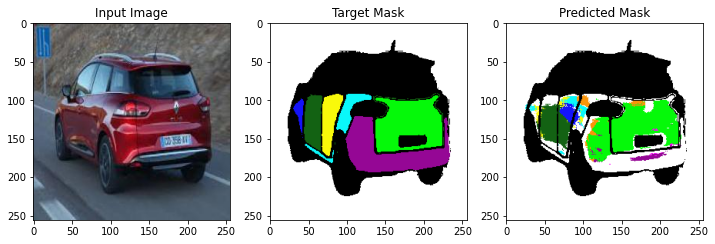

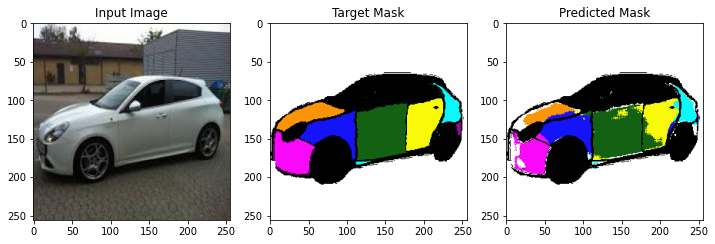

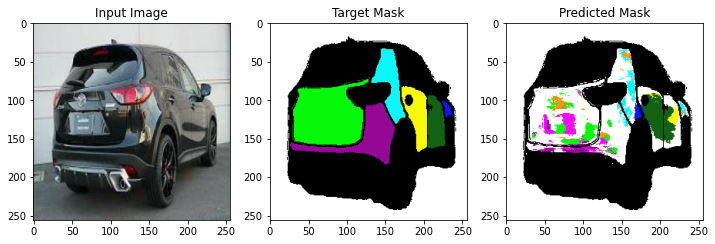

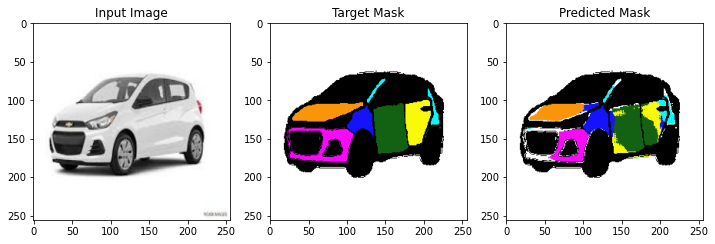

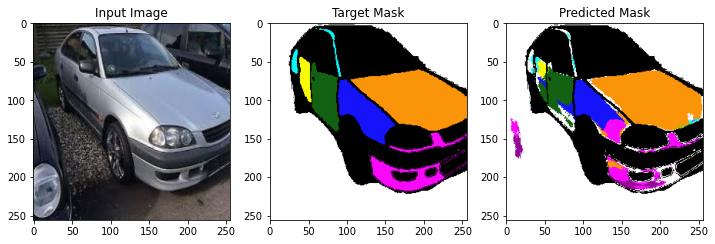

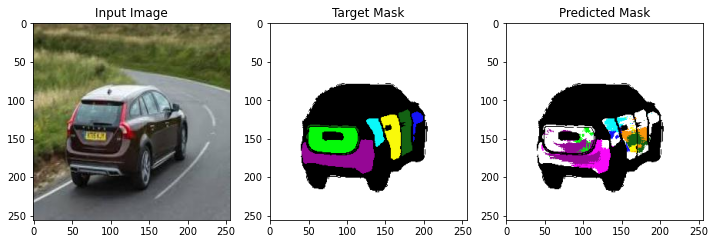

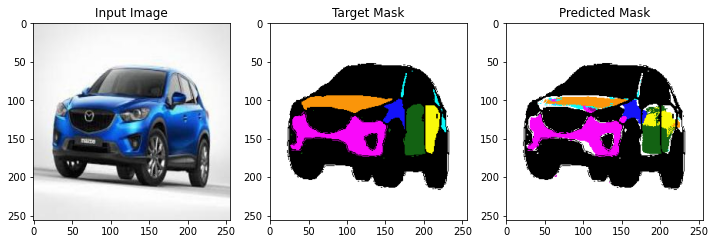

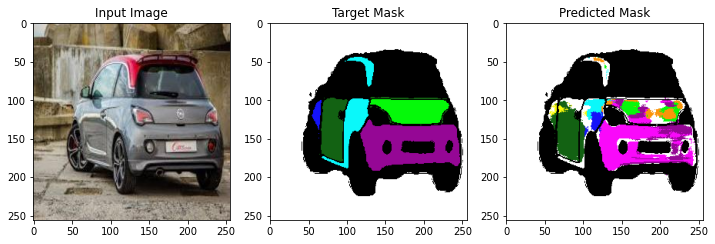

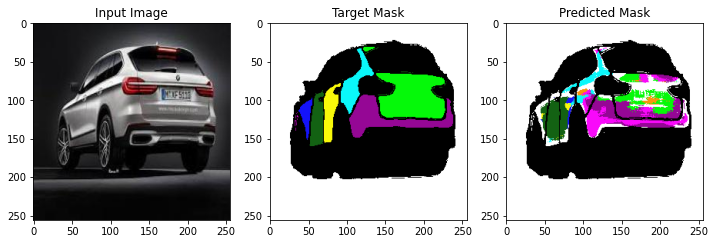

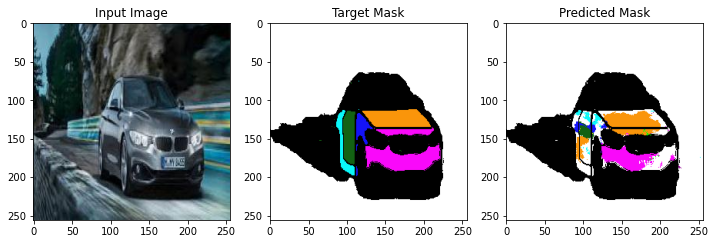

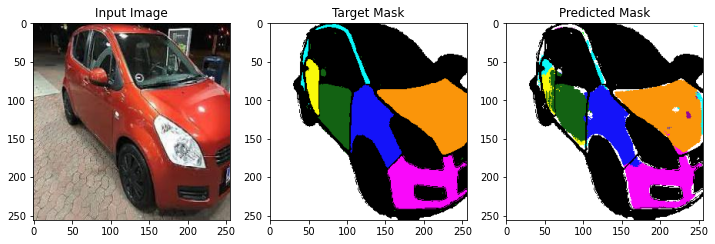

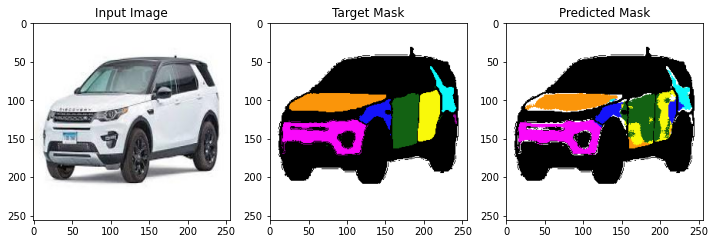

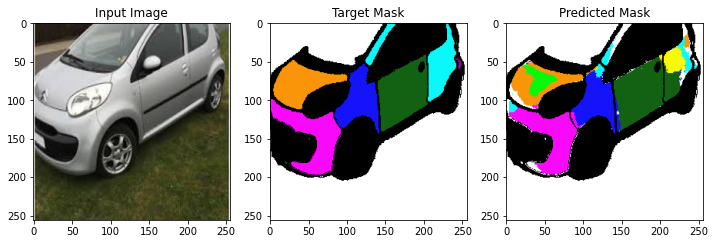

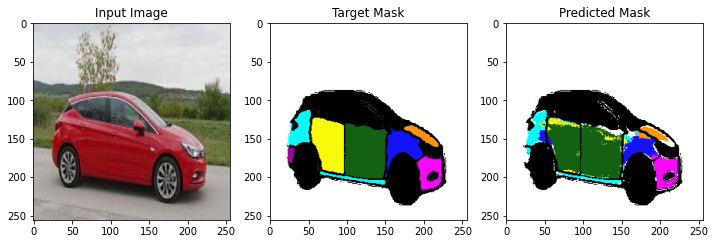

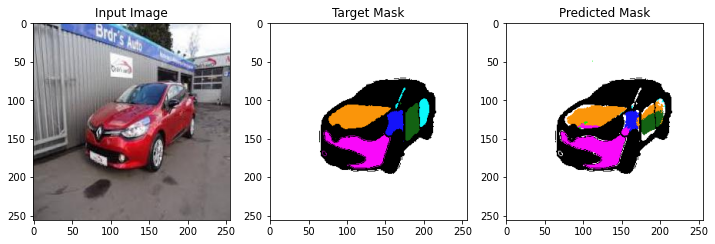

In [16]:
present_model('model_unetpp.pth', "unetpp")

In [17]:
present_model('model_unet.pth', "unet")

FileNotFoundError: [Errno 2] No such file or directory: 'model_unet.pth'